In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
import logging
import os
import pprint
from os import listdir
from os.path import isfile, join
from pathlib import Path

import brian2 as b2
import brian2hears as b2h
import dill
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
from IPython.display import display
from sorcery import dict_of

import consts as C
from analyze import sound_analysis as SA
from cochleas.anf_utils import CheckThreshold
from cochleas.consts import CFMAX, CFMIN,NUM_CF
from cochleas.GammatoneCochlea import run_hrtf
from utils.custom_sounds import Tone
from utils.log import logger
from generate_results import CURRENT_TEST

2024-11-15 14:52:39,156 [INFO ]  

>>>>> start execution

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



num spikes for pop L_parrot_ANF=31967
num active for pop L_parrot_ANF=22838
rate for pop L_parrot_ANF=1.399728522637709
num spikes for pop L_GBC=4038
num active for pop L_GBC=1667
rate for pop L_GBC=2.4223155368926217
num spikes for pop L_SBC=23563
num active for pop L_SBC=8581
rate for pop L_SBC=2.7459503554364293
num spikes for pop L_MSO=3474
num active for pop L_MSO=1642
rate for pop L_MSO=2.115712545676005
num spikes for pop R_parrot_ANF=32211
num active for pop R_parrot_ANF=23007
rate for pop R_parrot_ANF=1.4000521580388576
num spikes for pop R_GBC=4124
num active for pop R_GBC=1683
rate for pop R_GBC=2.4503862150920974
num spikes for pop R_SBC=23536
num active for pop R_SBC=8574
rate for pop R_SBC=2.7450431537205504
num spikes for pop R_MSO=3502
num active for pop R_MSO=1628
rate for pop R_MSO=2.151105651105651


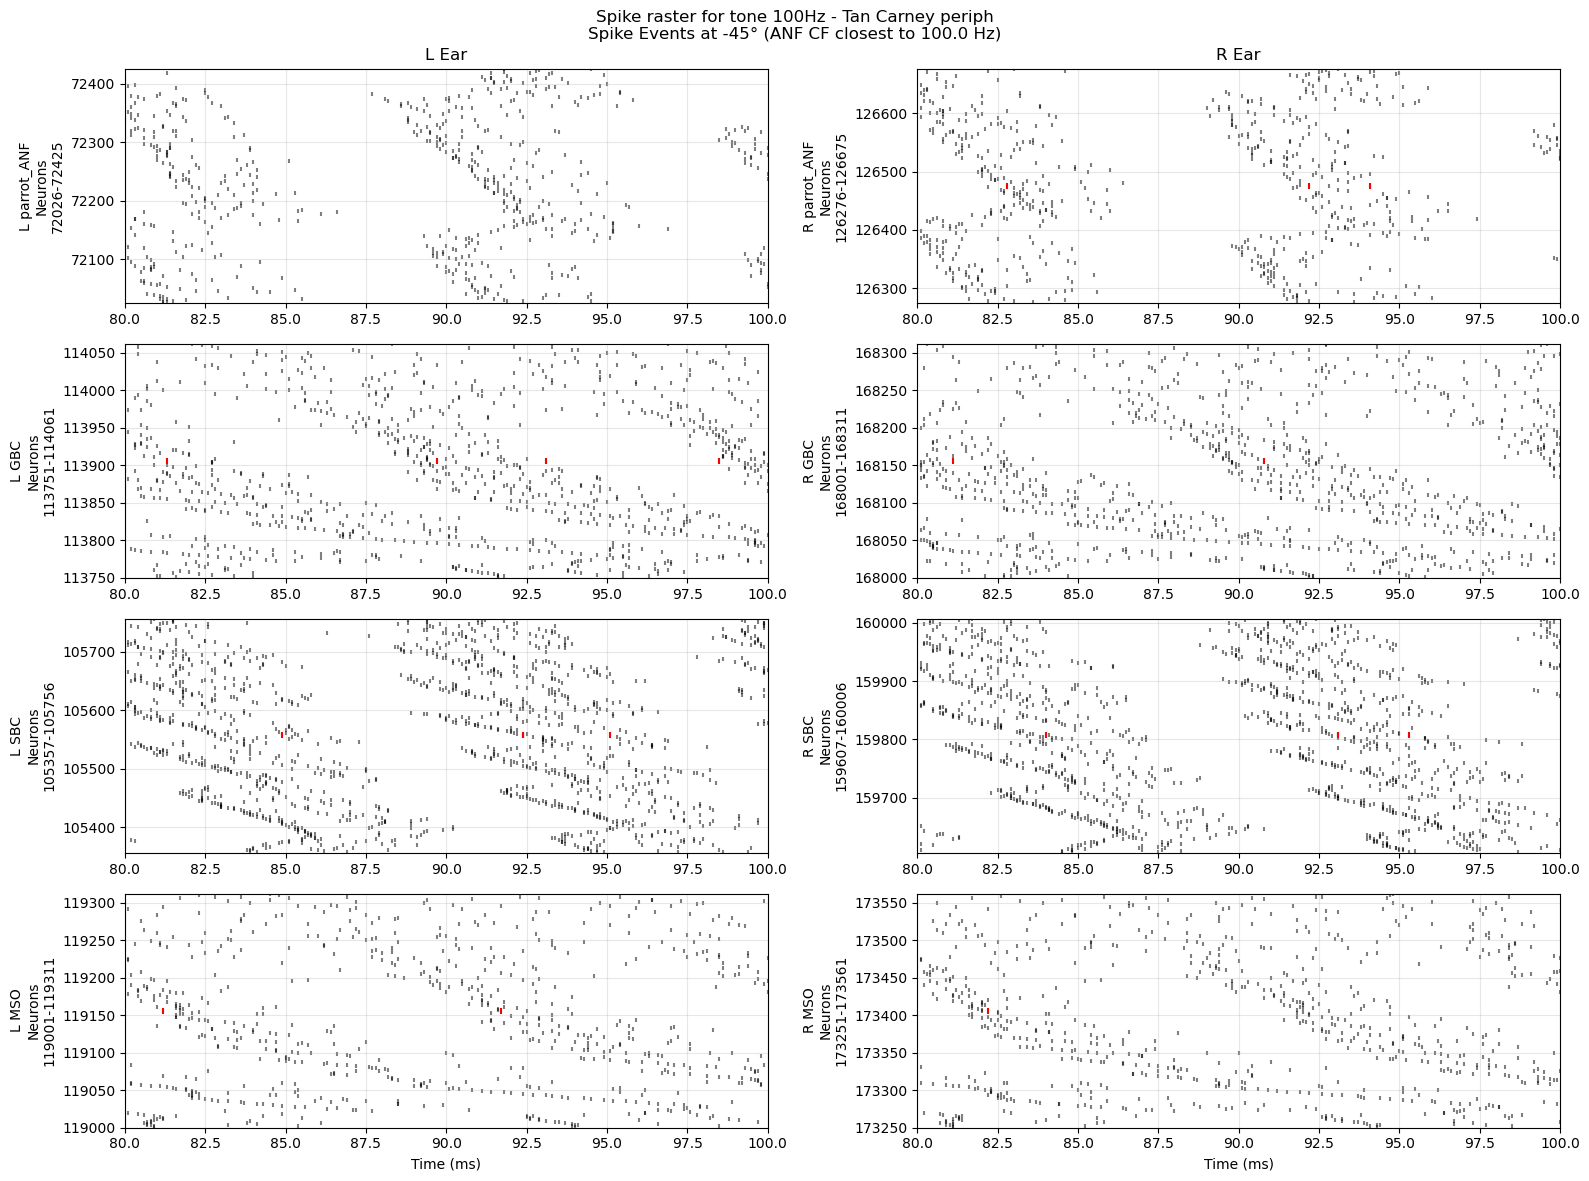

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from brian2.units import ms
from brian2hears import erbspace

# from models.InhModel.params import Parameters as InhParam


def find_closest_cf_index(tone_freq, cfmin, cfmax, num_cf):
    """
    Find the index of the characteristic frequency closest to the input tone frequency.
    """
    cf_array = erbspace(cfmin, cfmax, num_cf) / b2.Hz
    closest_idx = np.argmin(np.abs(cf_array - tone_freq))
    return closest_idx


def get_neuron_indices_and_ids(anf_idx, params, result, angle, side, range_size=400):
    indices = {
        "parrot_ANF": anf_idx,
        "SBC": anf_idx // params["POP_CONN"]["ANFs2SBCs"],
        "GBC": anf_idx // params["POP_CONN"]["ANFs2GBCs"],
    }
    # One-to-one connections from GBC
    indices["LNTBC"] = indices["GBC"]
    indices["MNTBC"] = indices["GBC"]
    # x-to-one connections to MSO and LSO
    indices["MSO"] = indices["SBC"] // params["SBCs2MSOs"]
    indices["LSO"] = indices["SBC"] // params["SBCs2LSOs"]
    # One-to-one connection to ICC
    indices["ICC"] = indices["MSO"]

    global_id_ranges = {}
    half_range = range_size // 2
    for pop, idx in indices.items():
        pop_global_ids = result["angle_to_rate"][angle][side][pop]["global_ids"]
        target_idx = idx
        start_idx = max(0, target_idx - half_range)
        end_idx = min(len(pop_global_ids), target_idx + half_range)
        # if pop == "parrot_ANF":
        #     start_idx = max(0, target_idx - half_range * 20)
        #     end_idx = min(len(pop_global_ids), target_idx + half_range * 20)
        global_id_ranges[pop] = pop_global_ids[start_idx:end_idx]

    return global_id_ranges, indices


def draw_all_pops_for_angle_in_range(
    result, name, angle, time_range, cfmin, cfmax, num_cf, figure_size=(16, 12)
):
    start_time = time_range.start / b2.ms
    stop_time = time_range.stop / b2.ms
    tone_freq = float(result["basesound"].frequency)
    # tone_freq = float(100)

    # Find the closest CF and corresponding ANF index
    cf_idx = find_closest_cf_index(tone_freq, cfmin, cfmax, num_cf)
    # print(cf_idx)
    anf_idx = cf_idx * 10 + 5  # Select middle ANF from the group of 10

    populations = ["parrot_ANF", "GBC", "SBC", 'MSO']
    sides = ["L", "R"]
    # Create figure
    fig, axes = plt.subplots(len(populations), 2, figsize=figure_size)
    fig.suptitle(
        f"{name}\nSpike Events at {angle}° (ANF CF closest to {tone_freq:.1f} Hz)"
    )
    for j, side in enumerate(sides):
        global_id_ranges, target_indices = get_neuron_indices_and_ids(
            anf_idx, result["conf"]["parameters"], result, angle, side
        )
        for i, pop in enumerate(populations):
            ax = axes[i, j]

            # Get spike data
            pop_data = result["angle_to_rate"][angle][side][pop]
            times = pop_data["times"]
            senders = pop_data["senders"]
            plot_times = []

            # Filter by time range and selected neuron
            time_mask = (times >= start_time) & (times <= stop_time)
            plot_times = times[time_mask]
            plot_senders = senders[time_mask]
            # Create mask for neurons in our range
            range_mask = np.isin(plot_senders, global_id_ranges[pop])
            range_times = plot_times[range_mask]
            range_senders = plot_senders[range_mask]

            # Plot spikes
            if len(range_times) > 0:
                # Plot all neurons in range
                ax.scatter(
                    range_times,
                    range_senders,
                    marker="|",
                    color="black",
                    alpha=0.5,
                    s=10,
                )

                # Highlight target neuron
                target_mask = (
                    range_senders
                    == global_id_ranges[pop][len(global_id_ranges[pop]) // 2]
                )
                num_spikes = len(plot_times)
                num_active = len(set(plot_senders))
                print(f"num spikes for pop {side}_{pop}={num_spikes}")
                print(f"num active for pop {side}_{pop}={num_active}")
                print(f"rate for pop {side}_{pop}={num_spikes/num_active}")
                ax.scatter(
                    range_times[target_mask],
                    range_senders[target_mask],
                    marker="|",
                    color="red",
                    s=15,
                )

            # Customize plot
            ax.set_ylabel(
                f"{side} {pop}\nNeurons\n{global_id_ranges[pop][0]}-{global_id_ranges[pop][-1]}"
            )
            if i == len(populations) - 1:  # Bottom row
                ax.set_xlabel("Time (ms)")

            # Set y-limits to show only our range of neurons
            ax.set_ylim(min(global_id_ranges[pop]) - 1, max(global_id_ranges[pop]) + 1)
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.set_title(f"{side} Ear")
            ax.set_xlim(start_time, stop_time)
    plt.tight_layout()
    return fig


time_range = slice(80 * ms, 100 * ms)
results_dir = (
    Path(os.getcwd())
    / Path(C.Paths.RESULTS_DIR)
    / 'produce_for_thesis'
    / "withICC&TanCarney&FIXMSONOW"
)
selected = "2024-11-15T14:38:54&tone_100.Hz_70dB&TanCarney&withICC&FIXMSONOW.pic"
with open(join(results_dir, selected), "rb") as f:
    with dill.detect.trace():
        res = dill.load(f, ignore=False)
        fig = draw_all_pops_for_angle_in_range(
            res,
            "Spike raster for tone 100Hz - Tan Carney periph",
            angle=-45,
            time_range=time_range,
            cfmin=CFMIN,
            cfmax=CFMAX,
            num_cf=NUM_CF,
        )
        plt.show()

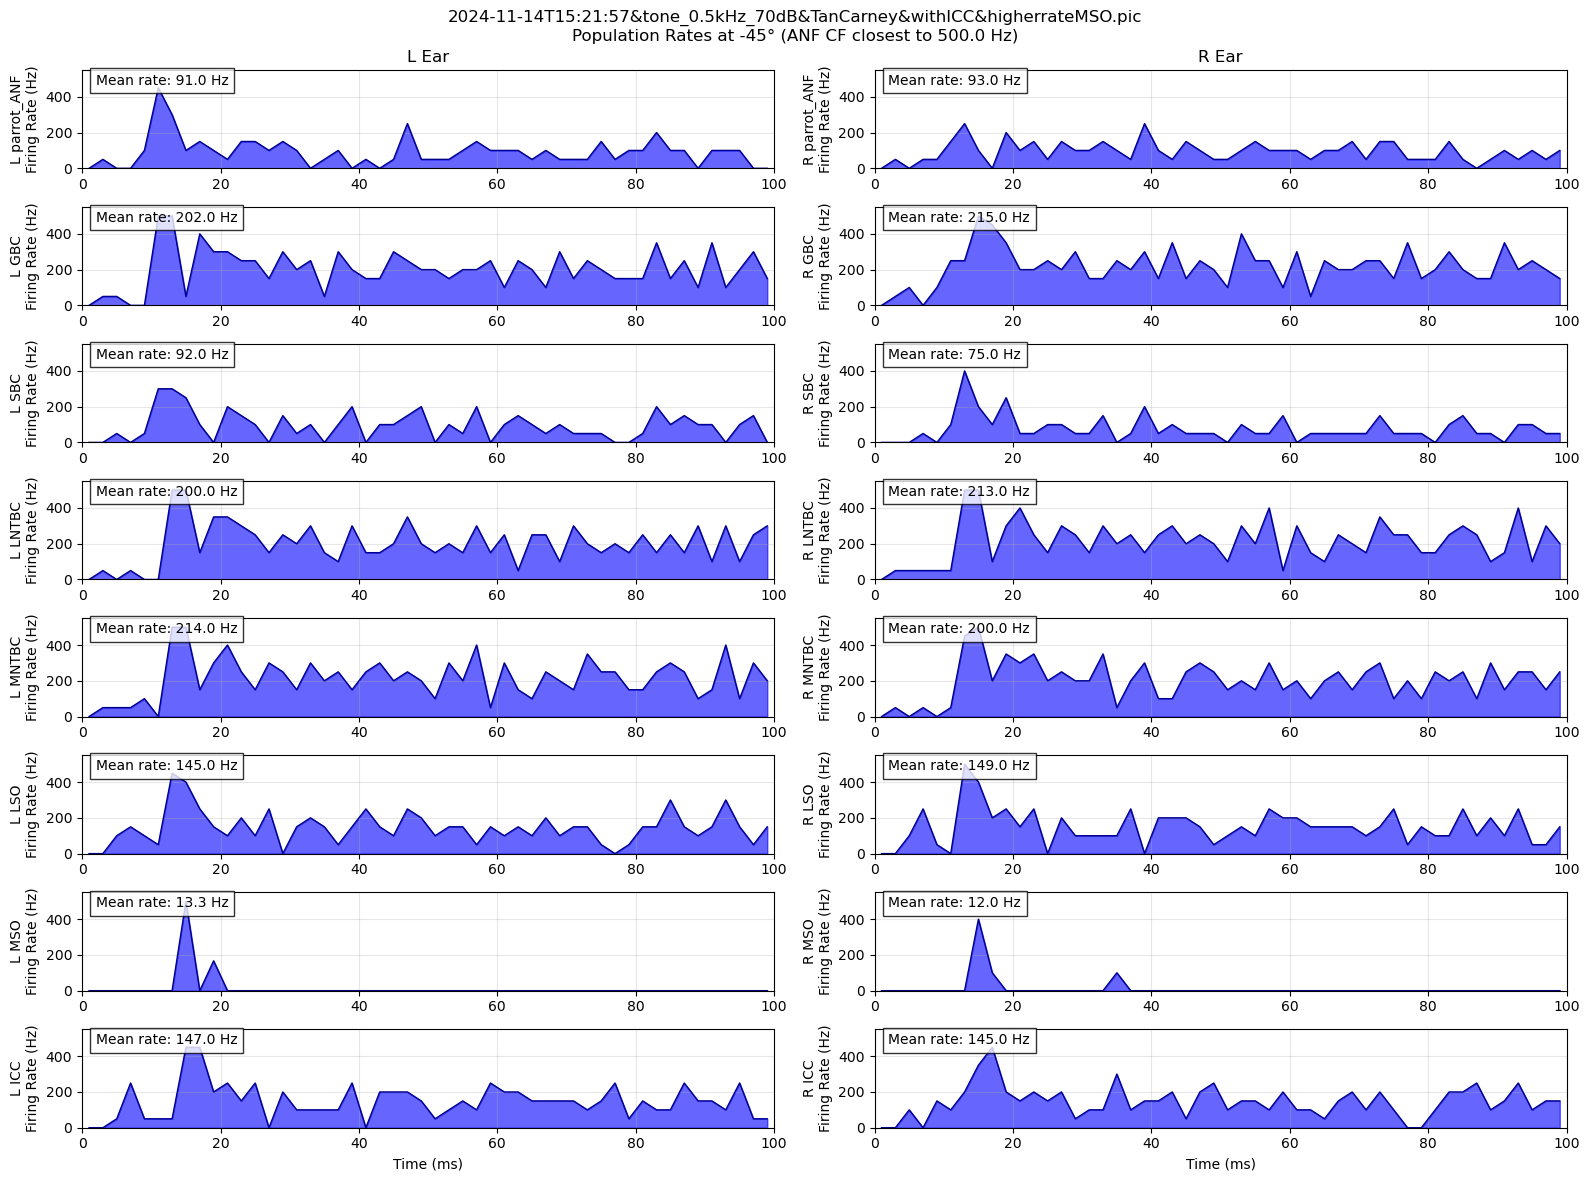

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from brian2.units import ms

def calculate_population_rates(times, senders, time_range, bin_size=2):
    """
    Calculate firing rates for a population in time bins.
    
    Args:
        times (array): Spike times in ms
        senders (array): Neuron IDs that generated the spikes
        time_range (slice): Time range to analyze (in ms)
        bin_size (float): Size of time bins in ms
    
    Returns:
        tuple: (bin_centers, rates)
    """
    # Create time bins
    bins = np.arange(time_range.start/ms, time_range.stop/ms + bin_size, bin_size)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Count spikes in each bin
    spike_counts, _ = np.histogram(times, bins=bins)
    
    # Calculate rate (spikes/sec) = (spike_count/num_neurons) * (1000ms/bin_size)
    num_neurons = len(np.unique(senders))
    rates = (spike_counts / num_neurons) * (1000/bin_size) if num_neurons > 0 else np.zeros_like(spike_counts)
    
    return bin_centers, rates

def get_neuron_indices_and_ids(anf_idx, params, result, angle, side, range_size=10):
    indices = {
        "parrot_ANF": anf_idx,
        "SBC": anf_idx // params["POP_CONN"]["ANFs2SBCs"],
        "GBC": anf_idx // params["POP_CONN"]["ANFs2GBCs"],
    }
    # One-to-one connections from GBC
    indices["LNTBC"] = indices["GBC"]
    indices["MNTBC"] = indices["GBC"]
    # x-to-one connections to MSO and LSO
    indices["MSO"] = indices["SBC"] // params["SBCs2MSOs"]
    indices["LSO"] = indices["SBC"] // params["SBCs2LSOs"]
    # One-to-one connection to ICC
    indices["ICC"] = indices["MSO"]

    global_id_ranges = {}
    half_range = range_size // 2
    for pop, idx in indices.items():
        pop_global_ids = result["angle_to_rate"][angle][side][pop]["global_ids"]
        target_idx = idx
        start_idx = max(0, target_idx - half_range)
        end_idx = min(len(pop_global_ids), target_idx + half_range)
        # if pop == "parrot_ANF":
        #     start_idx = max(0, target_idx - half_range * 20)
        #     end_idx = min(len(pop_global_ids), target_idx + half_range * 20)
        global_id_ranges[pop] = pop_global_ids[start_idx:end_idx]

    return global_id_ranges, indices

def draw_population_rates(
    result, name, angle, time_range, cfmin, cfmax, num_cf, figure_size=(16, 12)
):
    """
    Draw population firing rates over time for all populations.
    """
    start_time = time_range.start / ms
    stop_time = time_range.stop / ms
    tone_freq = float(result["basesound"].frequency)
    
    # Find the closest CF and corresponding ANF index
    cf_idx = find_closest_cf_index(tone_freq, cfmin, cfmax, num_cf)
    anf_idx = cf_idx * 10 + 5
    
    populations = ["parrot_ANF", "GBC", "SBC", "LNTBC", "MNTBC", "LSO", "MSO", "ICC"]
    # populations = ["parrot_ANF"]
    sides = ["L", "R"]
    
    # Create figure
    fig, axes = plt.subplots(len(populations), 2, figsize=figure_size)
    fig.suptitle(
        f"{name}\nPopulation Rates at {angle}° (ANF CF closest to {tone_freq:.1f} Hz)"
    )
    
    # Track max rate for consistent color scaling
    max_rate = 0
    
    # First pass to get max rate for color normalization
    for side in sides:
        global_id_ranges, target_indices = get_neuron_indices_and_ids(
            anf_idx, result["conf"]["parameters"], result, angle, side
        )
        for pop in populations:
            pop_data = result["angle_to_rate"][angle][side][pop]
            times = pop_data["times"]
            senders = pop_data["senders"]
            
            # Filter by time range and selected neurons
            time_mask = (times >= start_time) & (times <= stop_time)
            plot_times = times[time_mask]
            plot_senders = senders[time_mask]
            range_mask = np.isin(plot_senders, global_id_ranges[pop])
            range_times = plot_times[range_mask]
            
            # Calculate rates
            _, rates = calculate_population_rates(range_times, plot_senders[range_mask], time_range)
            max_rate = max(max_rate, np.max(rates)) if len(rates) > 0 else max_rate
    
    # Create plots
    for j, side in enumerate(sides):
        global_id_ranges, target_indices = get_neuron_indices_and_ids(
            anf_idx, result["conf"]["parameters"], result, angle, side
        )
        for i, pop in enumerate(populations):
            ax = axes[i, j]
            
            # Get spike data
            pop_data = result["angle_to_rate"][angle][side][pop]
            times = pop_data["times"]
            senders = pop_data["senders"]
            
            # Filter data
            time_mask = (times >= start_time) & (times <= stop_time)
            plot_times = times[time_mask]
            plot_senders = senders[time_mask]
            range_mask = np.isin(plot_senders, global_id_ranges[pop])
            # range_mask = [True] *len(plot_senders)
            range_times = plot_times[range_mask]
            
            # Calculate and plot rates
            bin_centers, rates = calculate_population_rates(
                range_times, plot_senders[range_mask], time_range
            )
            
            if len(bin_centers) > 0:
                # Plot rates as a filled curve
                ax.fill_between(bin_centers, rates, alpha=0.6, color='blue')
                ax.plot(bin_centers, rates, color='darkblue', linewidth=1)
                
                # Add mean rate text
                mean_rate = np.mean(rates)
                ax.text(0.02, 0.85, f'Mean rate: {mean_rate:.1f} Hz', 
                       transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
            
            # Customize plot
            ax.set_ylabel(f"{side} {pop}\nFiring Rate (Hz)")
            if i == len(populations) - 1:
                ax.set_xlabel("Time (ms)")
            
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.set_title(f"{side} Ear")
            ax.set_xlim(start_time, stop_time)
            ax.set_ylim(0, max_rate * 1.1)  # Add 10% margin
    
    plt.tight_layout()
    return fig

# Example usage:
time_range = slice(0* ms, 100 * ms)
results_dir = (
    Path(os.getcwd())
    / Path(C.Paths.RESULTS_DIR)
    / 'produce_for_thesis'
    / "withICC&TanCarney&higherrateMSO"
)
selected = "2024-11-14T15:21:57&tone_0.5kHz_70dB&TanCarney&withICC&higherrateMSO.pic"
with open(join(results_dir, selected), "rb") as f:
    with dill.detect.trace():
        res = dill.load(f, ignore=False)
        fig = draw_population_rates(
            res,
            selected,
            angle=-45,
            time_range=time_range,
            cfmin=CFMIN,
            cfmax=CFMAX,
            num_cf=NUM_CF,
        )
        plt.show()

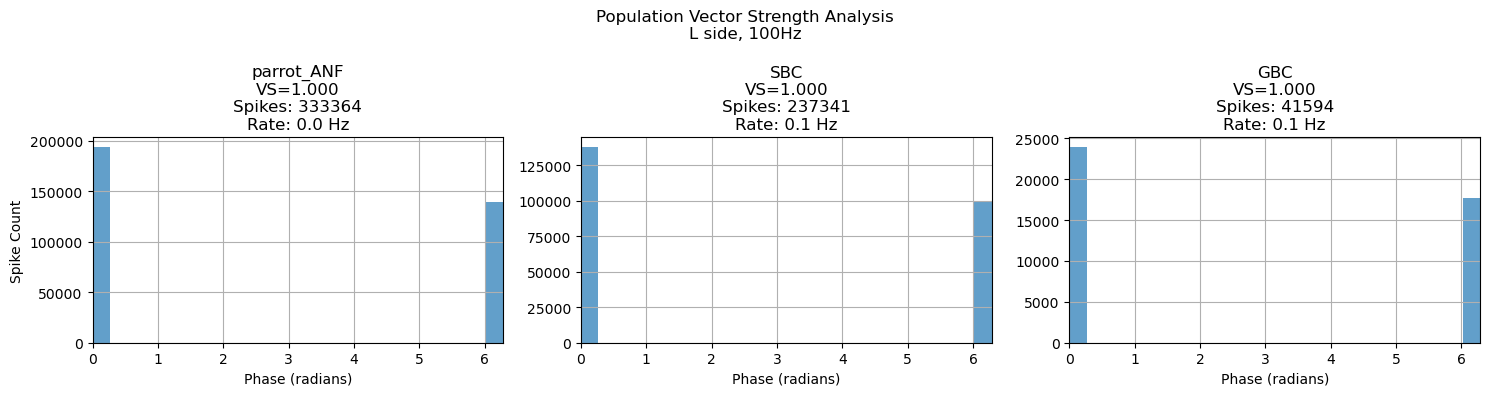

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple


def get_spike_phases(spike_times: np.ndarray, frequency: float) -> np.ndarray:
    """Calculate the phase of each spike relative to the stimulus frequency"""
    return 2 * np.pi * frequency * (spike_times % (1 / frequency))


def calculate_vector_strength(spike_times: np.ndarray, frequency: float) -> float:
    """Calculate vector strength for a set of spike times"""
    if len(spike_times) == 0:
        return 0
    phases = get_spike_phases(spike_times, frequency)
    x = np.mean(np.cos(phases))
    y = np.mean(np.sin(phases))
    return np.sqrt(x**2 + y**2)




def plot_population_vector_strength(
    result: Dict,
    frequency: float,
    populations: List[str] = ["parrot_ANF", "SBC", "GBC"],
    side: str = "L",
    n_bins: int = 24,
) -> Tuple[plt.Figure, Dict[str, float]]:
    """
    Plot vector strength analysis for entire populations

    Args:
        result: Simulation result dictionary containing spike data
        frequency: Stimulus frequency in Hz
        populations: List of population names to analyze
        side: 'L' or 'R' for left/right side
        n_bins: Number of bins for phase histogram

    Returns:
        fig: The matplotlib figure
        vs_dict: Dictionary of vector strengths for each population
    """
    # Setup plot
    fig, axs = plt.subplots(1, len(populations), figsize=(5 * len(populations), 4))
    if len(populations) == 1:
        axs = [axs]

    # Setup bins for phase histogram
    bins = np.linspace(0, 2 * np.pi, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    vs_dict = {}  # Store vector strengths

    # Plot each population
    for ax, pop_name in zip(axs, populations):
        pop_data = result[side][pop_name]

        # Use all spike times for the population
        spike_times = pop_data["times"]

        # Calculate vector strength and phases
        vs = calculate_vector_strength(spike_times, frequency)
        vs_dict[pop_name] = vs
        phases = get_spike_phases(spike_times, frequency)

        # Plot histogram
        hist, _ = np.histogram(phases, bins=bins)
        ax.bar(bin_centers, hist, width=2 * np.pi / n_bins, alpha=0.7)

        # Calculate mean firing rate
        duration = np.max(spike_times) - np.min(spike_times)
        n_neurons = len(np.unique(pop_data["senders"]))
        rate = len(spike_times) / (duration * n_neurons) if duration > 0 else 0

        # Customize plot
        ax.set_title(
            f"{pop_name}\nVS={vs:.3f}\nSpikes: {len(spike_times)}\n"
            f"Rate: {rate:.1f} Hz"
        )
        ax.set_xlabel("Phase (radians)")
        ax.set_xlim(0, 2 * np.pi)
        if ax == axs[0]:
            ax.set_ylabel("Spike Count")

    plt.suptitle(f"Population Vector Strength Analysis\n{side} side, {frequency}Hz")
    plt.tight_layout()
    return fig, vs_dict


def print_population_stats(
    result: Dict,
    frequency: float,
    populations: List[str] = ["parrot_ANF", "SBC", "GBC"],
    side: str = "L",
) -> Dict[str, Dict]:
    """
    Print detailed statistics for each population
    """
    stats = {}

    for pop_name in populations:
        pop_data = result[side][pop_name]
        spike_times = pop_data["times"]

        # Basic statistics
        n_neurons = len(np.unique(pop_data["senders"]))
        duration = np.max(spike_times) - np.min(spike_times)
        total_spikes = len(spike_times)
        mean_rate = total_spikes / (duration * n_neurons) if duration > 0 else 0

        # Vector strength
        vs = calculate_vector_strength(spike_times, frequency)

        # Store stats
        stats[pop_name] = {
            "n_neurons": n_neurons,
            "total_spikes": total_spikes,
            "mean_rate": mean_rate,
            "vector_strength": vs,
            "duration": duration,
        }

        # Print summary
        print(f"\n{pop_name} Statistics:")
        print(f"  Neurons: {n_neurons}")
        print(f"  Total spikes: {total_spikes}")
        print(f"  Mean rate: {mean_rate:.1f} Hz")
        print(f"  Vector strength: {vs:.3f}")
        print(f"  Recording duration: {duration:.1f} ms")

    return stats


# def plot_population_vector_strength(
#     result: Dict,
#     frequency: float,
#     populations: List[str] = ["parrot_ANF", "SBC", "GBC"],
#     side: str = "L",
#     n_bins: int = 24,
#     neuron_index: int = 0,
# ) -> plt.Figure:
#     """
#     Plot vector strength analysis for specified populations

#     Args:
#         result: Simulation result dictionary containing spike data
#         frequency: Stimulus frequency in Hz
#         populations: List of population names to analyze
#         side: 'L' or 'R' for left/right side
#         n_bins: Number of bins for phase histogram
#         neuron_index: Index of the specific neuron to analyze in each population
#     """
#     # Setup plot
#     fig, axs = plt.subplots(1, len(populations), figsize=(5 * len(populations), 4))
#     if len(populations) == 1:
#         axs = [axs]

#     # Setup bins for phase histogram
#     bins = np.linspace(0, 2 * np.pi, n_bins + 1)
#     bin_centers = (bins[:-1] + bins[1:]) / 2

#     # Plot each population
#     for ax, pop_name in zip(axs, populations):
#         pop_data = result[side][pop_name]

#         # Get spike times for the specific neuron
#         neuron_id = pop_data["global_ids"][neuron_index]
#         mask = pop_data["senders"] == neuron_id
#         spike_times = pop_data["times"][mask]
#         print(spike_times)

#         # Calculate vector strength and phases
#         vs = calculate_vector_strength(spike_times, frequency)
#         phases = get_spike_phases(spike_times, frequency)

#         # Plot histogram
#         hist, _ = np.histogram(phases, bins=bins)
#         ax.bar(bin_centers, hist, width=2 * np.pi / n_bins, alpha=0.7)

#         # Customize plot
#         ax.set_title(f"{pop_name}\nVS={vs:.3f}\nSpikes: {len(spike_times)}")
#         ax.set_xlabel("Phase (radians)")
#         ax.set_xlim(0, 2 * np.pi)
#         if ax == axs[0]:
#             ax.set_ylabel("Spike Count")

#     plt.suptitle(
#         f"Vector Strength Analysis\nNeuron {neuron_index}, {side} side, {frequency}Hz"
#     )
#     plt.tight_layout()
#     return fig


# Example usage:
# Assuming 'simulation_result' is your simulation result dictionary and
# tone_frequency is your stimulus frequency in Hz:
results_dir = (
    Path(os.getcwd())
    / Path(C.Paths.RESULTS_DIR)
    / "produce_for_thesis"
    / "withICC&TanCarney&FIXMSONOW"
)
selected = "2024-11-15T14:38:54&tone_100.Hz_70dB&TanCarney&withICC&FIXMSONOW.pic"
with open(join(results_dir, selected), "rb") as f:
    simulation_result = dill.load(f)
    fig = plot_population_vector_strength(
        result=simulation_result['angle_to_rate'][-45],
        frequency=100,
        populations=["parrot_ANF", "SBC", "GBC"],
        side="L",
    )